## Zhanqian

In [63]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
zhanqian = pd.read_csv(os.getcwd() + '/data/zhanqian.csv', names=['year', 'month', 'day', 'hour', 'minute', 'exp', 'cong', 'block', 'unknown'])
date_cols = ['year','month','day','hour','minute']
zhanqian['date'] = pd.to_datetime(zhanqian[date_cols])
zhanqian = zhanqian.set_index('date').drop(date_cols, axis=1)
for col in zhanqian.columns:
    zhanqian[col] = zhanqian[col].str.rstrip('%').astype('float') / 100.0

In [52]:
zhanqian.head()

,exp,cong,block,unknown
date,,,,
2018-01-09 16:40:00,0.6250,0.2500,0.1250,0.0000
2018-01-09 16:45:00,0.6250,0.3750,0.0000,0.0000
2018-01-09 16:50:00,0.7500,0.1250,0.1250,0.0000
2018-01-09 16:55:00,0.5000,0.3750,0.1250,0.0000
2018-01-09 17:00:00,0.5714,0.1429,0.1429,0.1428


In [53]:
zhanqian = zhanqian.resample('10Min').mean().bfill()
zhanqian.head()

,exp,cong,block,unknown
date,,,,
2018-01-09 16:40:00,0.62500,0.3125,0.06250,0.00000
2018-01-09 16:50:00,0.62500,0.2500,0.12500,0.00000
2018-01-09 17:00:00,0.64285,0.1429,0.14290,0.07145
2018-01-09 17:10:00,0.71430,0.2143,0.00000,0.07140
2018-01-09 17:20:00,0.47220,0.4097,0.11805,0.00005


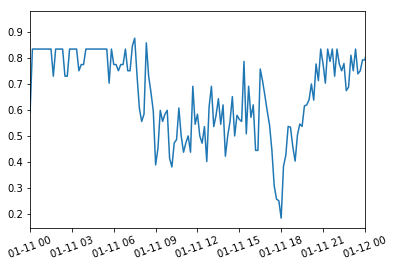

In [66]:
sns.lineplot(data=zhanqian['2018-01-11':'2018-01-12']['exp'])
plt.xlim(['2018-01-11', '2018-01-12'])
plt.xticks(rotation=20);